概率模型有时候既含有观测变量，又含有隐变量或潜在变量，如果概率模型的变量都是观测变量，那么给定数据，可以直接用极大似然估计法，或贝叶斯估计方法估计模型参数，但是当模型含有隐变量时，就不能简单的使用这些方法，EM算法就是含有隐变量的概率模型参数的极大似然估计法，或极大后验概率估计法，我们讨论极大似然估计，极大后验概率估计与其类似。
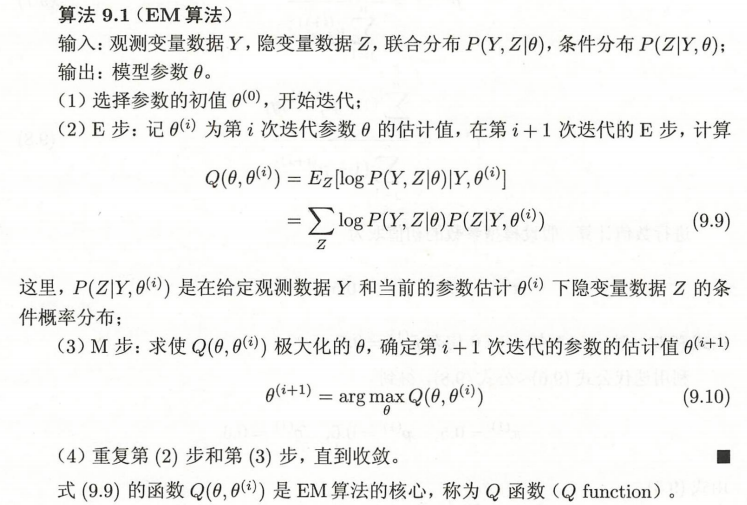
E步：固定θ，优化Q；M步：固定Q，优化θ；交替将极值推向最大

高斯混合分布：
多个高斯模型组合在一起的混合模型（可以理解为多个高斯分布函数的线性组合，理论上高斯混合模型是可以拟合任意类型的分布）

混合高斯分布模型
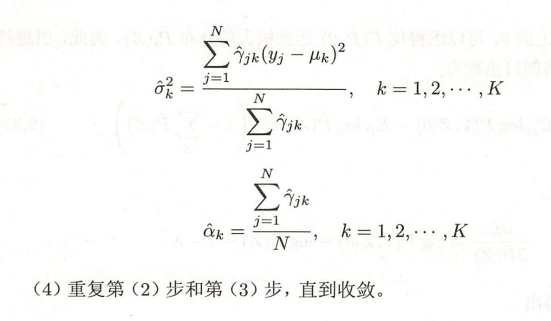

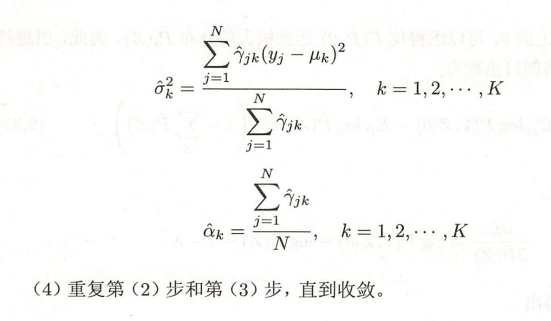
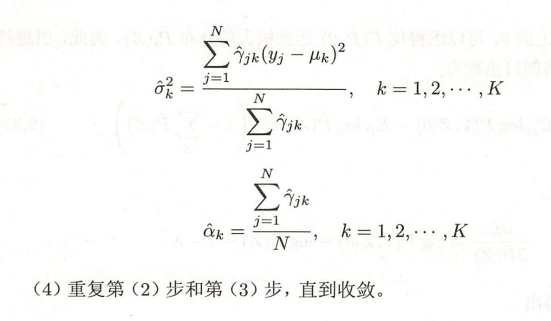


In [5]:
import numpy as np
import random
import math
import time

In [6]:
'''
数据集：伪造数据集（两个高斯分布混合）
数据集长度：1000
------------------------------
运行结果：
----------------------------
the Parameters set is:
alpha0:0.3, mu0:0.7, sigmod0:-2.0, alpha1:0.5, mu1:0.5, sigmod1:1.0
----------------------------
the Parameters predict is:
alpha0:0.4, mu0:0.6, sigmod0:-1.7, alpha1:0.7, mu1:0.7, sigmod1:0.9
----------------------------
'''

def loadData(mu0, sigma0, mu1, sigma1, alpha0, alpha1):
    '''
    初始化数据集
    这里通过服从高斯分布的随机函数来伪造数据集
    :param mu0: 高斯0的均值
    :param sigma0: 高斯0的方差
    :param mu1: 高斯1的均值
    :param sigma1: 高斯1的方差
    :param alpha0: 高斯0的系数
    :param alpha1: 高斯1的系数
    :return: 混合了两个高斯分布的数据
    '''
    # 定义数据集长度为1000
    length = 1000

    # 初始化第一个高斯分布，生成数据，数据长度为length * alpha系数，以此来
    # 满足alpha的作用
    data0 = np.random.normal(mu0, sigma0, int(length * alpha0))
    # 第二个高斯分布的数据
    data1 = np.random.normal(mu1, sigma1, int(length * alpha1))

    # 初始化总数据集
    # 两个高斯分布的数据混合后会放在该数据集中返回
    dataSet = []
    # 将第一个数据集的内容添加进去
    dataSet.extend(data0)
    # 添加第二个数据集的数据
    dataSet.extend(data1)
    # 对总的数据集进行打乱（其实不打乱也没事，只不过打乱一下直观上让人感觉已经混合了
    # 读者可以将下面这句话屏蔽以后看看效果是否有差别）
    random.shuffle(dataSet)

    #返回伪造好的数据集
    return dataSet

In [7]:

# 高斯分布公式，没有什么特殊的
def calcGauss(dataSetArr, mu, sigmod):
    '''
    根据高斯密度函数计算值
    依据：“9.3.1 高斯混合模型” 式9.25
    注：在公式中y是一个实数，但是在EM算法中(见算法9.2的E步)，需要对每个j
    都求一次yjk，在本实例中有1000个可观测数据，因此需要计算1000次。考虑到
    在E步时进行1000次高斯计算，程序上比较不简洁，因此这里的y是向量，在numpy
    的exp中如果exp内部值为向量，则对向量中每个值进行exp，输出仍是向量的形式。
    所以使用向量的形式1次计算即可将所有计算结果得出，程序上较为简洁
    
    :param dataSetArr: 可观测数据集
    :param mu: 均值
    :param sigmod: 方差
    :return: 整个可观测数据集的高斯分布密度（向量形式）
    '''
    # 计算过程就是依据式9.25写的，没有别的花样
    result = (1 / (math.sqrt(2*math.pi)*sigmod**2)) * np.exp(-1 * (dataSetArr-mu) * (dataSetArr-mu) / (2*sigmod**2))
    # 返回结果
    return result


def E_step(dataSetArr, alpha0, mu0, sigmod0, alpha1, mu1, sigmod1):
    '''
    EM算法中的E步
    依据当前模型参数，计算分模型k对观数据y的响应度
    :param dataSetArr: 可观测数据y
    :param alpha0: 高斯模型0的系数
    :param mu0: 高斯模型0的均值
    :param sigmod0: 高斯模型0的方差
    :param alpha1: 高斯模型1的系数
    :param mu1: 高斯模型1的均值
    :param sigmod1: 高斯模型1的方差
    :return: 两个模型各自的响应度
    '''
    # 计算y0的响应度
    # 先计算模型0的响应度的分子
    gamma0 = alpha0 * calcGauss(dataSetArr, mu0, sigmod0)
    #print("gamma0=",gamma0.shape) # 1000, 维向量
    # 模型1响应度的分子
    gamma1 = alpha1 * calcGauss(dataSetArr, mu1, sigmod1)

    # 两者相加为E步中的分布
    sum = gamma0 + gamma1
    # 各自相除，得到两个模型的响应度
    gamma0 = gamma0 / sum
    gamma1 = gamma1 / sum

    # 返回两个模型响应度
    return gamma0, gamma1

def M_step(muo, mu1, gamma0, gamma1, dataSetArr):
    # 依据算法9.2计算各个值
    # 这里没什么花样，对照书本公式看看这里就好了
    
    # np.dot 点积：[1,2] [2,3] = [2,6]
    mu0_new = np.dot(gamma0, dataSetArr) / np.sum(gamma0)
    mu1_new = np.dot(gamma1, dataSetArr) / np.sum(gamma1)

    # math.sqrt  平方根 
    sigmod0_new = math.sqrt(np.dot(gamma0, (dataSetArr - muo)**2) / np.sum(gamma0))
    sigmod1_new = math.sqrt(np.dot(gamma1, (dataSetArr - mu1)**2) / np.sum(gamma1))

    alpha0_new = np.sum(gamma0) / len(gamma0)
    alpha1_new = np.sum(gamma1) / len(gamma1)

    # 将更新的值返回
    return mu0_new, mu1_new, sigmod0_new, sigmod1_new, alpha0_new, alpha1_new


## 训练主函数
def EM_Train(dataSetList, iter=500):
    '''
    根据EM算法进行参数估计
    算法依据“9.3.2 高斯混合模型参数估计的EM算法” 算法9.2
    :param dataSetList:数据集（可观测数据）
    :param iter: 迭代次数
    :return: 估计的参数
    '''
    # 将可观测数据y转换为数组形式，主要是为了方便后续运算
    dataSetArr = np.array(dataSetList)

    # 步骤1：对参数取初值，开始迭代
    alpha0 = 0.5
    mu0 = 0
    sigmod0 = 1
    alpha1 = 0.5
    mu1 = 1
    sigmod1 = 1

    # 开始迭代
    step = 0
    while (step < iter):
        # 每次进入一次迭代后迭代次数加1
        step += 1
        # 步骤2：E步：依据当前模型参数，计算分模型k对观测数据y的响应度
        gamma0, gamma1 = E_step(dataSetArr, alpha0, mu0, sigmod0, alpha1, mu1, sigmod1)
        # 步骤3：M步
        mu0, mu1, sigmod0, sigmod1, alpha0, alpha1 = M_step(mu0, mu1, gamma0, gamma1, dataSetArr)

    # 迭代结束后将更新后的各参数返回
    return alpha0, mu0, sigmod0, alpha1, mu1, sigmod1


In [8]:

if __name__ == '__main__':
    start = time.time()

    # 设置两个高斯模型进行混合，这里是初始化两个模型各自的参数
    # 见“9.3 EM算法在高斯混合模型学习中的应用”
    # alpha是“9.3.1 高斯混合模型” 定义9.2中的系数α
    # mu0是均值μ
    # sigmod是方差σ
    # 在设置上两个alpha的和必须为1，其他没有什么具体要求，符合高斯定义就可以
    
    alpha0 = 0.3  # 系数α
    mu0 = -2  # 均值μ
    sigmod0 = 0.5  # 方差σ

    alpha1 = 0.7  # 系数α
    mu1 = 0.5  # 均值μ
    sigmod1 = 1  # 方差σ

    # 初始化数据集
    dataSetList = loadData(mu0, sigmod0, mu1, sigmod1, alpha0, alpha1)

    #打印设置的参数
    print('---------------------------')
    print('the Parameters set is:')
    print('alpha0:%.1f, mu0:%.1f, sigmod0:%.1f, alpha1:%.1f, mu1:%.1f, sigmod1:%.1f' % (
        alpha0, alpha1, mu0, mu1, sigmod0, sigmod1
    ))

    # 开始EM算法，进行参数估计
    alpha0, mu0, sigmod0, alpha1, mu1, sigmod1 = EM_Train(dataSetList)

    # 打印参数预测结果
    print('----------------------------')
    print('the Parameters predict is:')
    print('alpha0:%.1f, mu0:%.1f, sigmod0:%.1f, alpha1:%.1f, mu1:%.1f, sigmod1:%.1f' % (
        alpha0, alpha1, mu0, mu1, sigmod0, sigmod1
    ))

    # 打印时间
    print('----------------------------')
    print('time span:', time.time() - start)

---------------------------
the Parameters set is:
alpha0:0.3, mu0:0.7, sigmod0:-2.0, alpha1:0.5, mu1:0.5, sigmod1:1.0
----------------------------
the Parameters predict is:
alpha0:0.3, mu0:0.7, sigmod0:-1.8, alpha1:0.7, mu1:0.6, sigmod1:0.9
----------------------------
time span: 0.04385018348693848


In [9]:
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [10]:
#生成随机数据，4个高斯模型
def generate_data(sigma,N,mu1,mu2,mu3,mu4,alpha):
    global X                  #可观测数据集
    X = np.zeros((N, 2))       # 初始化X，2行N列。2维数据，N个样本
    X=np.matrix(X)
    global mu                 #随机初始化mu1，mu2，mu3，mu4
    mu = np.random.random((4,2))
    mu=np.matrix(mu)
    global excep              #期望第i个样本属于第j个模型的概率的期望
    excep=np.zeros((N,4))
    global alpha_             #初始化混合项系数
    alpha_=[0.25,0.25,0.25,0.25]
    for i in range(N):
        if np.random.random(1) < 0.1:  # 生成0-1之间随机数
            X[i,:]  = np.random.multivariate_normal(mu1, sigma, 1)     #用第一个高斯模型生成2维数据
        elif 0.1 <= np.random.random(1) < 0.3:
            X[i,:] = np.random.multivariate_normal(mu2, sigma, 1)      #用第二个高斯模型生成2维数据
        elif 0.3 <= np.random.random(1) < 0.6:
            X[i,:] = np.random.multivariate_normal(mu3, sigma, 1)      #用第三个高斯模型生成2维数据
        else:
            X[i,:] = np.random.multivariate_normal(mu4, sigma, 1)      #用第四个高斯模型生成2维数据
 
    print("可观测数据：\n",X)       #输出可观测样本
    print("初始化的mu1，mu2，mu3，mu4：",mu)      #输出初始化的mu


# E 期望
#  \hat{\gamma_{jk}}
def e_step(sigma,k,N):
    global X
    global mu
    global excep
    global alpha_
    for i in range(N):
        denom=0
        for j in range(0,k):
            #  sigma.I 表示矩阵的逆矩阵
            # np.transpose ：矩阵转置   np.linalg.det():矩阵求行列式
            denom += alpha_[j]*  math.exp(-(X[i,:]-mu[j,:])*sigma.I*np.transpose(X[i,:]-mu[j,:]))  /np.sqrt(np.linalg.det(sigma))       #分母
        for j in range(0,k):
            numer = math.exp(-(X[i,:]-mu[j,:])*sigma.I*np.transpose(X[i,:]-mu[j,:]))/np.sqrt(np.linalg.det(sigma))        #分子
            excep[i,j]=alpha_[j]*numer/denom      #求期望
    print("隐藏变量：\n",excep)

    
def m_step(k,N):
    global excep
    global X
    global alpha_
    for j in range(0,k):
        denom=0   #分母
        numer=0   #分子
        for i in range(N):
            numer += excep[i,j]*X[i,:]
            denom += excep[i,j]
        mu[j,:] = numer/denom    #求均值
        alpha_[j]=denom/N        #求混合项系数

        #     #可视化结果
def plotShow():
    # 画生成的原始数据
    plt.subplot(221)
    plt.scatter(X[:,0].tolist(), X[:,1].tolist(),c='b',s=25,alpha=0.4,marker='o')    #T散点颜色，s散点大小，alpha透明度，marker散点形状
    plt.title('random generated data')
    #画分类好的数据
    plt.subplot(222)
    plt.title('classified data through EM')
    order=np.zeros(N)
    color=['b','r','k','y']
    for i in range(N):
        for j in range(k):
            if excep[i,j]==max(excep[i,:]):
                order[i]=j     #选出X[i,:]属于第几个高斯模型
            probility[i] += alpha_[int(order[i])]*math.exp(-(X[i,:]-mu[j,:])*sigma.I*np.transpose(X[i,:]-mu[j,:]))/(np.sqrt(np.linalg.det(sigma))*2*np.pi)    #计算混合高斯分布
        plt.scatter(X[i, 0], X[i, 1], c=color[int(order[i])], s=25, alpha=0.4, marker='o')      #绘制分类后的散点图
    #绘制三维图像
    ax = plt.subplot(223, projection='3d')
    plt.title('3d view')
    for i in range(N):
        ax.scatter(X[i, 0], X[i, 1], probility[i], c=color[int(order[i])])
    plt.show()

In [11]:
        
if __name__ == '__main__':
    iter_num=1000  #迭代次数
    N=500         #样本数目
    k=4            #高斯模型数
    probility = np.zeros(N)    #混合高斯分布
    u1=[5,35]
    u2=[30,40]
    u3=[20,20]
    u4=[45,15]
    sigma=np.matrix([[30, 0], [0, 30]])               #协方差矩阵
    alpha=[0.1,0.2,0.3,0.4]         #混合项系数
    generate_data(sigma,N,u1,u2,u3,u4,alpha)     #生成数据
    #迭代计算
    for i in range(iter_num):
        err=0     #均值误差
        err_alpha=0    #混合项系数误差
        Old_mu = copy.deepcopy(mu)
        Old_alpha = copy.deepcopy(alpha_)
        
        e_step(sigma,k,N)     # E步
        m_step(k,N)           # M步
        
        print("迭代次数:",i+1)
        print("估计的均值:",mu)
        print("估计的混合项系数:",alpha_)
        for z in range(k):
            err += (abs(Old_mu[z,0]-mu[z,0])+abs(Old_mu[z,1]-mu[z,1]))      #计算误差
            err_alpha += abs(Old_alpha[z]-alpha_[z])
        if (err<=0.001) and (err_alpha<0.001):     #达到精度退出迭代
            print(err,err_alpha)
            break


可观测数据：
 [[25.79932773 16.30822101]
 [ 8.8744077  18.57764942]
 [20.8701041  19.79185342]
 [46.65578312 18.3083259 ]
 [29.27853891 44.24491248]
 [42.0392861  20.10930842]
 [-1.04568215 42.91913483]
 [17.6609774  19.74040828]
 [ 1.6972288  34.19424745]
 [47.6893786  16.22778426]
 [45.7911472  29.6294377 ]
 [45.36601935 10.72905616]
 [45.03215257 10.62774396]
 [39.19561394 12.52666943]
 [30.28913105 37.91840719]
 [48.53755937  8.00961545]
 [14.93772732 18.36823922]
 [36.74456431 43.54765528]
 [40.10412935 14.98730381]
 [ 5.87429751 37.09866377]
 [20.83574268 19.39535364]
 [28.36181212 37.99894038]
 [30.84346619 19.79176874]
 [ 0.57187794 32.27790988]
 [24.45710253 33.10397318]
 [25.79599849 41.89452165]
 [45.84948937  3.84951998]
 [57.62661674 18.47112253]
 [46.60406543 14.33681416]
 [12.3273749  34.95587615]
 [34.43093136 43.14955987]
 [28.37502674 31.66624142]
 [ 2.77738186 34.99194649]
 [ 6.61369242 47.60672552]
 [12.16252036 28.52579133]
 [34.10266488 23.44619634]
 [44.37163748  9.872

隐藏变量：
 [[0.15056466 0.19793857 0.3628972  0.28859958]
 [0.23685669 0.3085645  0.25342345 0.20115536]
 [0.17961427 0.24482554 0.32549371 0.25006649]
 ...
 [0.06894332 0.09176802 0.46715008 0.37213858]
 [0.16027035 0.22421548 0.35112571 0.26438846]
 [0.13932775 0.21316407 0.38110505 0.26640313]]
迭代次数: 1
估计的均值: [[25.65326233 26.25910338]
 [25.3726486  27.97302196]
 [35.41345043 21.121742  ]
 [35.88439534 19.79575022]]
估计的混合项系数: [0.13962575234292915, 0.21280655126671025, 0.37099344225352215, 0.27657425413683834]
隐藏变量：
 [[2.39284826e-01 1.05509160e-01 3.66088523e-01 2.89117492e-01]
 [5.60429261e-01 4.39561770e-01 6.49951205e-06 2.46869219e-06]
 [5.72068744e-01 4.11850478e-01 1.07405310e-02 5.34024640e-03]
 ...
 [6.67193526e-08 1.42223318e-08 3.33768453e-01 6.66231466e-01]
 [4.68895411e-01 3.51425939e-01 1.18153091e-01 6.15255597e-02]
 [1.38820763e-01 1.68003955e-01 4.93812409e-01 1.99362874e-01]]
迭代次数: 2
估计的均值: [[19.67094446 24.23638944]
 [20.76326564 34.17610588]
 [41.60123621 17.91191271]

隐藏变量：
 [[9.70348104e-01 1.22618671e-06 2.86510704e-02 9.99599705e-04]
 [1.00000000e+00 6.84264478e-13 1.68290777e-15 5.03181322e-19]
 [9.99997807e-01 3.44140712e-07 1.84523166e-06 3.23510527e-09]
 ...
 [2.97377104e-17 3.85320405e-15 6.45421445e-02 9.35457856e-01]
 [9.95627864e-01 9.80934309e-05 4.26383591e-03 1.02064890e-05]
 [5.11475718e-03 1.07288080e-01 8.87174906e-01 4.22256965e-04]]
迭代次数: 15
估计的均值: [[15.22758407 24.42249642]
 [30.11007784 39.82622356]
 [41.59450997 20.11331601]
 [44.8336838  11.64591086]]
估计的混合项系数: [0.31045885183990296, 0.202527312530561, 0.19020160865575045, 0.296812226973785]
隐藏变量：
 [[9.65795591e-01 1.24317863e-06 3.32551207e-02 9.48044944e-04]
 [1.00000000e+00 6.74462688e-13 2.15444617e-15 4.41224407e-19]
 [9.99997466e-01 3.46198688e-07 2.18458581e-06 3.00623998e-09]
 ...
 [2.81127900e-17 3.86910662e-15 6.31637919e-02 9.36836208e-01]
 [9.95007533e-01 9.93220781e-05 4.88345676e-03 9.68842157e-06]
 [4.78832381e-03 1.02465518e-01 8.92358573e-01 3.87584978e-04]]
迭代

 [[2.71198407e-01 7.20701396e-07 7.28576849e-01 2.24023330e-04]
 [1.00000000e+00 5.08994716e-13 3.84287151e-12 6.09866238e-20]
 [9.99677835e-01 4.90166851e-07 3.21673285e-04 1.68590158e-09]
 ...
 [3.52044933e-18 3.59903707e-15 1.13820404e-02 9.88617960e-01]
 [7.91874667e-01 1.39629307e-04 2.07978124e-01 7.57938429e-06]
 [6.36797412e-04 3.00924391e-02 9.69133105e-01 1.37658759e-04]]
迭代次数: 29
估计的均值: [[14.43305107 24.95276786]
 [30.30725399 39.83466881]
 [37.34434956 19.03509515]
 [45.85582729 12.91761116]]
估计的混合项系数: [0.2917596082726698, 0.20097534265592876, 0.17844973105677278, 0.3288153180146288]
隐藏变量：
 [[1.65874606e-01 5.04804413e-07 8.33953503e-01 1.71386452e-04]
 [1.00000000e+00 4.81284077e-13 1.21726467e-11 6.68974221e-20]
 [9.99316509e-01 5.23070138e-07 6.82965946e-04 2.06773154e-09]
 ...
 [2.38967564e-18 3.56986429e-15 7.39081804e-03 9.92609182e-01]
 [6.77339245e-01 1.33092495e-04 3.22519326e-01 8.33671425e-06]
 [4.63549702e-04 2.55544513e-02 9.73840274e-01 1.41724787e-04]]
迭代次数: 

隐藏变量：
 [[1.52999803e-11 1.71174302e-08 9.99931256e-01 6.87265097e-05]
 [4.39034426e-03 4.30419267e-12 9.95609656e-01 9.68818280e-17]
 [7.98159687e-08 6.58524673e-08 9.99999845e-01 9.63200663e-09]
 ...
 [3.22714504e-33 8.46212307e-15 1.18911101e-11 1.00000000e+00]
 [2.39084714e-09 6.03907661e-06 9.99985271e-01 8.68759600e-06]
 [2.92472218e-10 3.97805588e-01 5.61746636e-01 4.04477757e-02]]
迭代次数: 44
估计的均值: [[ 5.54826602 34.9723615 ]
 [30.77735466 39.61211957]
 [20.75552079 19.63273107]
 [44.27675246 14.70754028]]
估计的混合项系数: [0.1022029324859335, 0.20015681990667442, 0.23690984677645235, 0.4607304008309395]
隐藏变量：
 [[1.52532129e-11 1.71605937e-08 9.99931192e-01 6.87910422e-05]
 [4.37886224e-03 4.30992991e-12 9.95621138e-01 9.68296055e-17]
 [7.95943486e-08 6.59842889e-08 9.99999845e-01 9.63722412e-09]
 ...
 [3.20641609e-33 8.47232008e-15 1.18574246e-11 1.00000000e+00]
 [2.38415571e-09 6.05249922e-06 9.99985249e-01 8.69599157e-06]
 [2.91412738e-10 3.98337502e-01 5.61188152e-01 4.04743457e-02]]


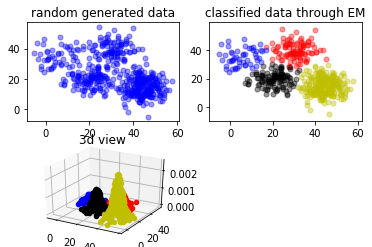

In [12]:
# 画图
plotShow()